In [110]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing math and scipy.stats
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import math

In [111]:
# Importing insurance data with pd.read_csv
insurance = pd.read_csv('Data/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [112]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Q1. Do smokers have higher insurance charges than non-smokers?

In [113]:
smokers = insurance.loc[insurance['smoker'] == 'yes', 'charges']
non_smokers = insurance.loc[insurance['smoker'] == 'no', 'charges']

1. State your Null Hypothesis and Alternative Hypothesis.

- [`H0`]: "There is no difference in the average insurance charges between smokers and non-smokers"
- [`H1`]: "Smokers have higher average insurance charges than non-smokers"

2. Select the correct test according to the data type and number of samples.

Since the data above are from different groups, I will perform an indepedent t-test to see the statical difference or if these results are valid due to the random sampling.

3. Test the assumptions of your selected test.

In [114]:
# Testing is theres outliers in the data
zscores_s = stats.zscore(smokers)
zscores_ns = stats.zscore(non_smokers)

# Removing outliers
smokers = smokers[(np.abs(zscores_s) < 3) & (np.abs(zscores_s) > -3)]
non_smokers = non_smokers[(np.abs(zscores_ns) < 3) & (np.abs(zscores_ns) > -3)]

# Checking is theres outliers in the data
zscores_s = stats.zscore(smokers)
zscores_ns = stats.zscore(non_smokers)

outliers_s = abs(zscores_s) > 3
outliers_ns = abs(zscores_ns) > 3

print(f'Outliers in smokers: {outliers_s.sum()}')
print(f'Outliers in non-smokers: {outliers_ns.sum()}')


Outliers in smokers: 0
Outliers in non-smokers: 19


In [115]:
print('Normality Test for Smokers')
print('Smokers:', stats.normaltest(smokers))
print('Normality Test for Non-Smokers')
print('Non-Smokers:', stats.normaltest(non_smokers))

# Printing equal variance test
print('Equal Variance Test')
print(stats.levene(smokers, non_smokers))

Normality Test for Smokers
Smokers: NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)
Normality Test for Non-Smokers
Non-Smokers: NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)
Equal Variance Test
LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [116]:
# Independent t-test with equal_var=False
result = stats.ttest_ind(smokers, non_smokers, equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

5. Interpret your p-value and reject or fail to reject your null hypothesis

In [117]:
if result.pvalue < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


6. Show a supporting visulaztion that helps display the result.

<AxesSubplot: xlabel='smoker', ylabel='charges'>

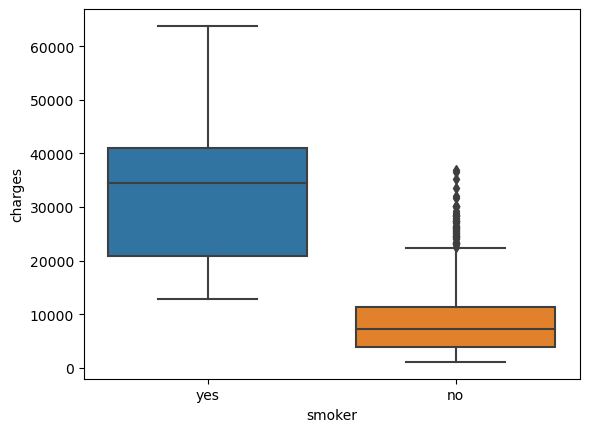

In [118]:
sns.boxplot(x='smoker', y='charges', data=insurance)

# Q2. Are men more likely to smoke than women?

1. State your Null Hyothesis and Alternative Hypothesis

- [`H0`] - Men are not, more likely to smoke than women.

- [`H1`] - Men are more likely to smoke, rather than women.

2. Select the correct test according to the data type and number of samples.

Because the data type are `'Objects'` we will be using Chi-Squared Test to perform this analysis on this dataset.

3. Test the assumptions of your selected test.

In [119]:
# First we need to calculate the contigency table with pd.crosstab
table = pd.crosstab(insurance['smoker'], insurance['sex'])
table

sex,female,male
smoker,,
no,547,517
yes,115,159


4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [120]:
# Running the Test and Saving the ouput in a variable
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected = result # unpacking the result

In [121]:
# Printing the p-value
print('p-value:', p)
p < 0.05

p-value: 0.006548143503580696


True

5. Interpret your p-value and reject or fail to reject your null hypothesis

In [122]:
if p < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


6. Show a supporting visulaztion that helps display the result.

Text(0.5, 1.0, 'Count of smokers by sex')

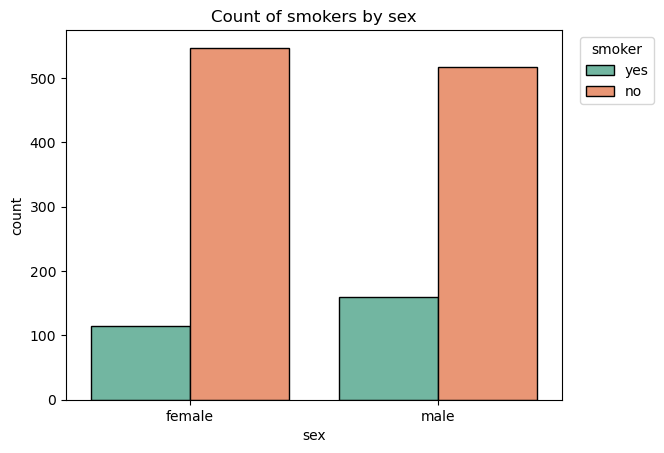

In [123]:
ax = sns.countplot(data=insurance, x='sex', hue='smoker', palette='Set2', edgecolor='black', linewidth=1)
sns.move_legend(ax,loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_title('Count of smokers by sex')

# Q3. Do different regions have different charges, on average?

1. State your Null Hypothesis and Alternative Hypothesis

- [`H0`] - There is no difference in what region has the most or least population of smokers
- [`H1`] - There is a significant difference in what region has the most or least population of smokers

2. Select the correct test according to the data type and number of samples

Since this is a multi-categorical problem, I will be performing an `ANOVA` Test to determine the p-value.

3. Test the assumptions of your selected test.

In [124]:
## Creating groups dictionary
groups = {}
## Looping through all unique values in the region column
for region in insurance['region'].unique():
    ## Getting series of charges for each region
    data = insurance[insurance['region'] == region]['charges']
    # Saving the series in the dictionary
    groups[region] = data

# Looping through the keys and values in the groups dictionary to perform a normal test on each group
# and comfirming there are > 20 in each group
normal_test = {}

for key, value in groups.items():
    stat, p = stats.normaltest(value)
    normal_test[key] = {'n': len(value), 'p': p, 'test stat': stat}
    print(f'{key}: {len(value)}')

# Converting the normal_test dictionary to a dataframe
normal_test_df = pd.DataFrame(normal_test).T
normal_test_df

southwest: 325
southeast: 364
northwest: 325
northeast: 324


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [125]:
normal_test_df['sig'] = normal_test_df['p'] < 0.05
normal_test_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [126]:
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [127]:
stat, p = stats.f_oneway(*groups.values())
p

0.0308933560705201

5. Interpret your p-value and reject or fail to reject your null hypothesis

In [128]:
if p < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


6. Show a supporting visulaztion that helps display the result.

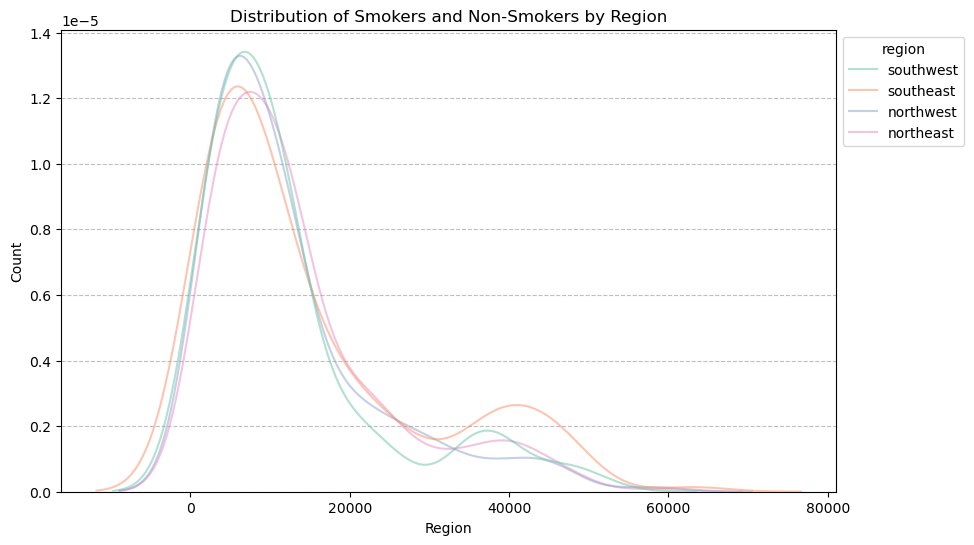

In [129]:
# ploting the distribution of charges by region
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.kdeplot(data=insurance, x='charges', hue='region', fill=False, palette='Set2', zorder=3, alpha=0.5, multiple='layer')
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
ax.set_title('Distribution of Smokers and Non-Smokers by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Count')
ax.grid(ls='--', alpha=0.5, color='grey', zorder=0, axis='y')
plt.show()